# EEG DataLoader

The dimensions of the training set are as follows: 4,500 samples, 64 channels, and a time length of 795. This corresponds to 5 categories in y_train.

The dimensions of the testing set are as follows: 750 samples, 64 channels, and a time length of 795. This corresponds to 5 categories in y_test.

You can download it from this Google Drive link: [https://drive.google.com/drive/folders/1ykR-mn4d4KfFeeNrfR6UdtebsNRY8PU2?usp=sharing].
Please download the data and place it in your data_path at "./data."

In [86]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchviz import make_dot

In [23]:
data_path = '/Users/siddhartharaovs/Downloads/CS555-Agile project Files/BCI_project/'

In [24]:
train_data = np.load(data_path + 'train_data.npy')
test_data = np.load(data_path + 'test_data.npy')
train_label = np.load(data_path + 'train_label.npy')
test_label = np.load(data_path + 'test_label.npy')

#To convert the data into PyTorch tensors
x_train_tensor = torch.Tensor(train_data)
y_train_tensor = torch.LongTensor(train_label)
x_test_tensor = torch.Tensor(test_data)
y_test_tensor = torch.LongTensor(test_label)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Setting GPU on your computer

In [26]:
train_dataset = TensorDataset(x_train_tensor.to(device), y_train_tensor.to(device)) # input data to Tensor dataloader
train_loader = DataLoader(train_dataset, batch_size=64, drop_last=True, shuffle=True) #  Batch size refers to the number of data sample
test_dataset = TensorDataset(x_test_tensor.to(device), y_test_tensor.to(device))
test_loader = DataLoader(test_dataset, batch_size=64,  drop_last=True,shuffle=False)

# Build simple Deep learning model

In [65]:
class EEGAutoencoderClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EEGAutoencoderClassifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 795, 512), # Input dimention is 64 channel * 795 time point, and use 256 units for first NN layer
            nn.ReLU(), # Use ReLu function for NN training
            nn.Linear(512, 256), # 256 NN units to 128 units
            nn.ReLU(),
            nn.Linear(256, 128),#  128 NN units to 64 units
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, num_classes), # num_classes is 5 ("hello,” “help me,” “stop,” “thank you,” and “yes”)
            nn.LogSoftmax(dim=1)  # Use LogSoftmax for multi-class classification
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)

        # import pdb;pdb.set_trace()
        x = self.classifier(x)
        return x

In [66]:
num_classes = 5 # setting final output class
model = EEGAutoencoderClassifier(num_classes).to(device)
criterion = nn.NLLLoss() # Use NLLLoss function to optimize
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Setting parameters learning rate = 0.001

In [67]:
num_epochs = 30 # setting training epochs (Number of training iterations)
for epoch in range(num_epochs):
    model.train()
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/30, Loss: 1.6831207275390625
Epoch 2/30, Loss: 1.5356062650680542
Epoch 3/30, Loss: 1.2985827922821045
Epoch 4/30, Loss: 1.1021382808685303
Epoch 5/30, Loss: 1.1042430400848389
Epoch 6/30, Loss: 0.9137059450149536
Epoch 7/30, Loss: 0.6911194920539856
Epoch 8/30, Loss: 0.6321732997894287
Epoch 9/30, Loss: 0.6413361430168152
Epoch 10/30, Loss: 0.3058575987815857
Epoch 11/30, Loss: 0.23612357676029205
Epoch 12/30, Loss: 0.1866004467010498
Epoch 13/30, Loss: 0.10164854675531387
Epoch 14/30, Loss: 0.14475949108600616
Epoch 15/30, Loss: 0.048630133271217346
Epoch 16/30, Loss: 0.07260194420814514
Epoch 17/30, Loss: 0.0492771677672863
Epoch 18/30, Loss: 0.1017569899559021
Epoch 19/30, Loss: 0.09183300286531448
Epoch 20/30, Loss: 0.09902249276638031
Epoch 21/30, Loss: 0.025553155690431595
Epoch 22/30, Loss: 0.027289139106869698
Epoch 23/30, Loss: 0.013777649030089378
Epoch 24/30, Loss: 0.10792078077793121
Epoch 25/30, Loss: 0.04498689994215965
Epoch 26/30, Loss: 0.02879740484058857
Epoc

In [68]:
model.eval() # Evaluate your model
correct = 0
total = 0

with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 53.98%


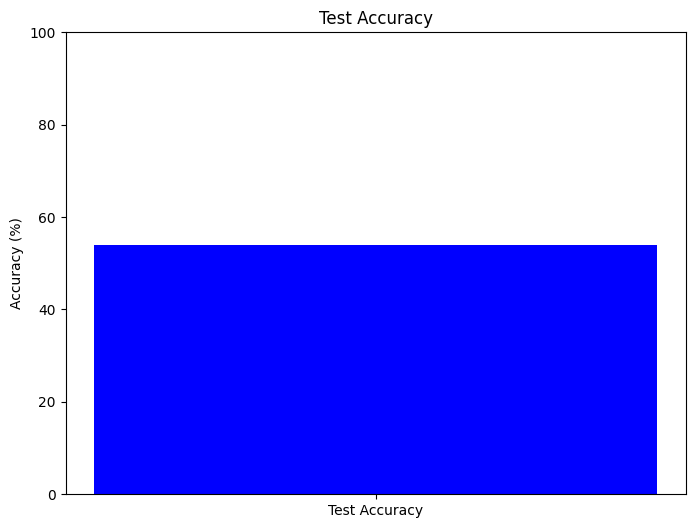

In [83]:
plt.figure(figsize=(8, 6))
plt.bar(["Test Accuracy"], [accuracy * 100], color='blue')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.ylim(0, 100)
plt.show()


In [88]:
model = EEGAutoencoderClassifier(num_classes).to(device)
dummy_input = torch.randn(1, 64 * 795).to(device)
output = model(dummy_input)
graph = make_dot(output, params=dict(model.named_parameters()))

#Save the graph
#graph.render(filename='model_graph', format='png')
# Display the graph
graph.view()

'Digraph.gv.pdf'